In [28]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import os
import cv2
import argparse

from model.model_builder import build_model
from utils.read_data import *

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [29]:
args = type('', (), {})() # create empty args

# PSMNet, PSMNet_Edge, GwcNet
args.model = 'PSMNet'
args.image_channels=3

args.min_disp=-96
args.max_disp=96

# GwcNet
args.groups=32


In [30]:
net = build_model(args)

# # PSMNet
net.load_state_dict(torch.load('logs_PSMNet/DFC2019_2024-06-07_23:25/20_epoch_PSMNet_DFC2019.pth'), strict=True)

net.eval()
net._disable_batchnorm_tracking()
net = net.to(device)


In [31]:
from utils.stereo_datasets import DFC2019, WHUStereo
# dataset = DFC2019(root = '/media/win_d/honghao/training_data/DFC2019/track2_grayscale',
#                                 resize = (1024,1024), 
#                                 min_disp = args.min_disp, max_disp = args.max_disp, image_set = 'testing')
dataset = WHUStereo(root = '/media/win_d/honghao/training_data/WHUStereo/WHUStereo_8UC3//with_ground_truth',
                                resize = (1024,1024), 
                                min_disp = args.min_disp, max_disp = args.max_disp, image_set = 'testing')


index = 66  # 76
left_path, right_path = dataset.image_list[index]
disp_path = dataset.disparity_list[index]


# left_path = 'img/left_temp_uint16_epi_tile0.tif'
# right_path = 'img/right_temp_uint16_epi_tile0.tif'

# left_path = 'img/JAX_427_018_003_LEFT_RGB.tif'
# right_path = 'img/JAX_427_018_003_RIGHT_RGB.tif'
# disp_path = 'img/JAX_427_018_003_LEFT_DSP.tif'

size = (1024, 1024)
# size = (1890, 2044)


In [32]:
img_l = read_img(left_path, size)
img_r = read_img(right_path, size)
print(img_l.shape, img_l.dtype)
# img_l = img_l[300:1324, 500:1524, :]
# img_r = img_r[300:1324, 500:1524, :]

if img_l.shape[2]==1:
    img_l = cv2.cvtColor(img_l, cv2.COLOR_GRAY2RGB)
    img_r = cv2.cvtColor(img_r, cv2.COLOR_GRAY2RGB)

tensor_l = img_norm(img_l)
tensor_r = img_norm(img_r)

if img_l.dtype == 'uint16' and len(img_l.shape)==2:
    tensor_l = tensor_l.unsqueeze(0).repeat(1,3,1,1).to(device)
    tensor_r = tensor_r.unsqueeze(0).repeat(1,3,1,1).to(device)
else:
    tensor_l = tensor_l.unsqueeze(0).to(device)
    tensor_r = tensor_r.unsqueeze(0).to(device)

(1024, 1024, 3) uint8


18.436554 -56.259438


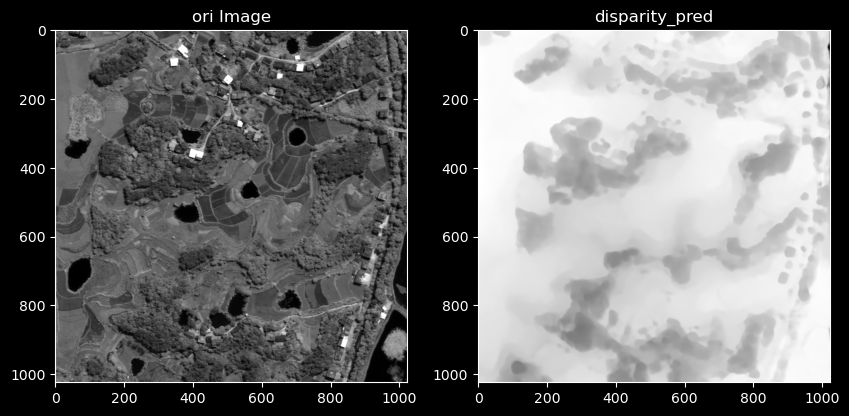

In [33]:
with torch.no_grad():
    disp_pred = net(tensor_l, tensor_r, args.min_disp, args.max_disp)
    disp_pred = disp_pred['final_disp'].squeeze().cpu().numpy()
    print(disp_pred.max(), disp_pred.min())

#visualize
# if img_l.dtype == 'uint16':
#     img_l = img_l.squeeze(2)

f, axis = plt.subplots(1, 2, figsize = (10,30))
axis[0].imshow(img_l)
# axis[0].imshow(disp_pred, alpha=0.5)
axis[0].set_title('ori Image')
axis[1].imshow(disp_pred, cmap='gray')
axis[1].set_title('disparity_pred')
plt.show()

In [34]:
from utils.metric import px_error, epe
# disp, valid = read_disp_whu(disp_path, size, -64, 64)
disp, valid = read_disp_dfc(disp_path, size, -96, 96)
disp_tensor = torch.from_numpy(disp).float()
vaild_tensor = torch.from_numpy(valid).bool()

epe = epe(disp_pred, disp , valid)
three_px = px_error(disp_pred, disp, valid, 3)

print('epe: ', epe)
print('3px_error: ', three_px*100)
print(disp[valid].max(), disp[valid].min())

epe:  6.887208709154815
3px_error:  92.02268102496258
18.186539 -30.636597


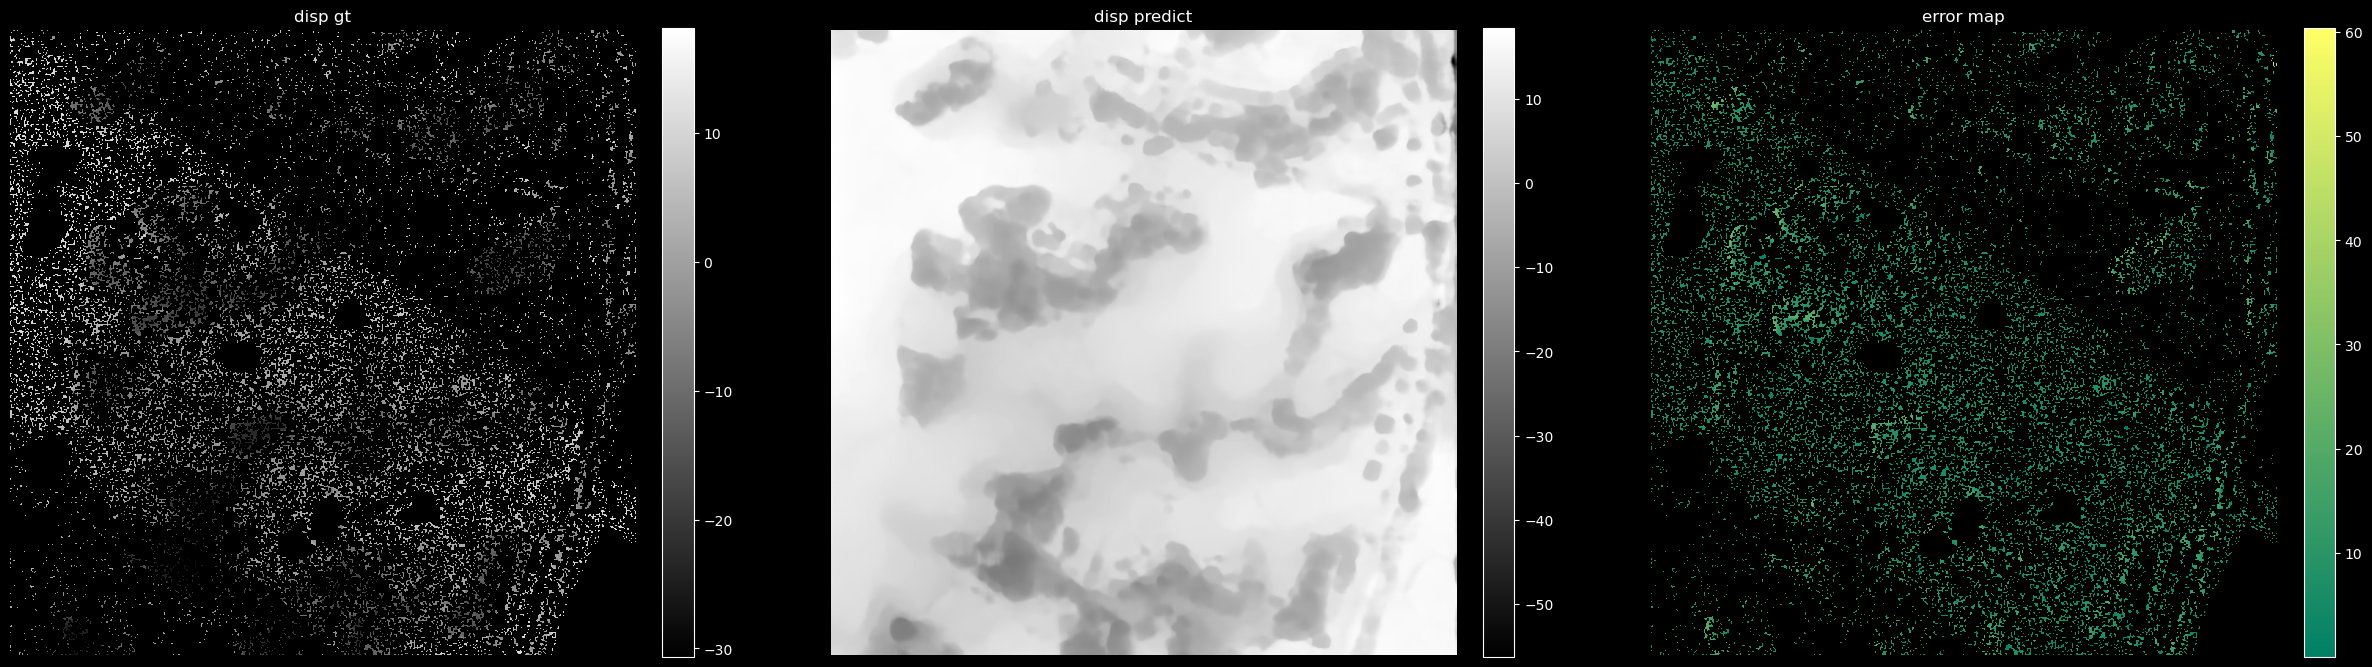

In [35]:
disp_error = np.abs(disp - disp_pred)
disp_error[~valid] = np.nan
disp[~valid] = np.nan

plt.figure(figsize=(30, 90))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(disp, cmap='gray')
plt.title('disp gt')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(disp_pred, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('disp predict')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(disp_error, cmap="summer")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('error map')

plt.show()

In [36]:
os.makedirs("demo_output", exist_ok=True)
cv2.imwrite('./demo_output/img.tif', disp_pred)

True